In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import pickle
import collections

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json
import string
from string import punctuation

In [5]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

In [6]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#import evaluate
import sys
import os

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    l = []
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        l.append(subtree.leaves())
    
    return l

def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    #word = stemmer.stem(word)
    #word = lemmatizer.lemmatize(word)
    return word

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted


def get_terms(tree):
    kp = []
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptable_word(w) ]
        if term:
            kp.append(term)
    
    return kp


In [7]:
def get_kp(text):
    
    # Used when tokenizing words
    sentence_re = r'''(?x)      # set flag to allow verbose regexps
            (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
          | \w+(?:-\w+)*        # words with optional internal hyphens
          | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
          | \.\.\.              # ellipsis
          | [][.,;"'?():_`-#]    # these are separate tokens; includes ], [
        '''

    #lemmatizer = nltk.WordNetLemmatizer()
    #stemmer = nltk.stem.porter.PorterStemmer()

    #Taken from Su Nam Kim Paper
    grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            {<JJ|JJR|JJS|VBG|VBN>*<NN|NNS|NNP|NNPS|VBG>}
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """

    #toks = nltk.regexp_tokenize(text, sentence_re)
    postoks = nltk.tag.pos_tag(text)
    chunker = nltk.RegexpParser(grammar)
    tree = chunker.parse(postoks)
    terms = get_terms(tree)
    #pos,pos_set = find_positions(text,terms)
    return terms#,pos,pos_set

In [8]:
data = 'Inspec/docsutf8/'
keys = 'Inspec/keys/'
files = os.listdir(data)
key_files = os.listdir(keys)

In [9]:
def find_positions(document,bert_tocs, kps):
    ''' 
    merge the same kps & keep present kps in document
    Inputs:
        document : a word list : ['sun', 'sunshine', ...] || lower cased
        kps : can have more than one kp : [['sun'], ['key','phrase'], ['sunshine']] || not duplicate
    Outputs:
        all_present_kps : present keyphrases
        positions_for_all : start_end_posisiton for prensent keyphrases
        a present kp postions list : every present's positions in documents, 
        each kp can be presented in several postions .
        [[[0,0],[20,21]], [[1,1]]]
    '''
    tot_doc_char = ' '.join(document)
    
    positions_for_all = []
    position_start,position_end =[],[]
    all_present_kps = []
    for kp in kps:
        ans_string = ' '.join(kp)
        
        if ans_string not in tot_doc_char:
            continue
        else: 
            positions_for_each = []
            # find all positions for each kp
            for i in range(0, len(bert_tocs) - len(kp) + 1):
                found = False
                search_str = ''
                if ans_string.startswith(bert_tocs[i]):
                    found = True
                    search_str +=bert_tocs[i]
                    search_idx = i
                    while found and search_idx<(len(bert_tocs)-1):
                        search_idx+=1
                        if search_str+bert_tocs[search_idx] in ans_string:
                            search_str+=bert_tocs[search_idx]
                        elif search_str+' '+bert_tocs[search_idx] in ans_string:
                            search_str+=' '+bert_tocs[search_idx]
                        else:
                            found = False
                        
                if (search_str==ans_string) and (i<search_idx):
                    assert len(kp) >= 1
                    positions_for_each.append((i+1, search_idx))
                    position_start.append(i+1)
                    position_end.append(search_idx)
                    
        if len(positions_for_each) > 0 :
            positions_for_all.extend(positions_for_each)
            all_present_kps.append(kp)
           
    assert len(positions_for_all) >= len(all_present_kps)
    
    if len(all_present_kps) == 0:
        return [None,None]
    return [position_start,position_end],set(positions_for_all)

In [10]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

In [11]:
def calculate_f1(y_labels,y_preds,depth,levels):
    precision = []
    recall = []
    f1 = []
    
    for idx,y_label in enumerate(y_labels):
        tp = 0
        p = []
        r = []
        y_label = set(np.where(y_label==1)[0])
        
        #print(y_preds[idx].shape)
        key_idx = np.argsort(-y_preds[idx])#[:,0])
        #print(sorted(-y_preds[idx]))
        y_new = np.sort(y_preds[idx])[::-1]
        #print(y_preds[idx])
        preds = key_idx[y_new>=0.5]
        for i in range(depth):
            if len(preds)>i:
                if preds[i] in y_label:
                    tp+=1
            p.append(tp/(min(i,len(preds))+1))
            r.append(tp/max(len(y_label),1))
    
    
        level_index = []
        level_p = []
        level_r = []
        for idx,level in enumerate(levels):
            level_p.append(p[level-1])
            level_r.append(r[level-1])
            if p[level-1]+r[level-1]>0:
                level_index.append(2*p[level-1]*r[level-1]/(p[level-1]+r[level-1]))
            else:
                level_index.append(0)
        #print('k',level_index)
        precision.append(level_p)
        recall.append(level_r)
        f1.append(level_index)
    precision = np.array(precision)
    recall = np.array(recall)
    f1 = np.array(f1)
    
    print('F1',np.mean(f1,axis=0),np.mean(precision,axis=0),np.mean(recall,axis=0))
    
                
            

In [12]:
vocab = "D:/Word embedding/bert/assets/vocab.txt"
tokenizer = BertWordPieceTokenizer(vocab, lowercase=True)
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
x_train = tf.convert_to_tensor(np.loadtxt('data/Inspec/x_train.csv'))
x_mask = tf.convert_to_tensor(np.loadtxt('data/Inspec/x_mask.csv'))
with open('data/Inspec/x_pos.pkl','rb') as f:
    x_pos = tf.convert_to_tensor(pickle.load(f))
    print(x_pos.shape)

with open('data/Inspec/y_train.pkl','rb') as f:
    y_train = tf.convert_to_tensor(pickle.load(f))
    print(y_train.shape)

(1984, 2, 154)
(1984, 154, 2)


In [14]:
max_len = 512
max_kp = 154

In [15]:
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
embedding = encoder(input_ids, attention_mask=attention_mask)[0]

bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(36,
                                                             kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.00,stddev=0.15),
                                                             dropout = 0.15,
                                                             return_sequences=True),
                                                             merge_mode=None)(embedding)
pos_mask = tf.keras.layers.Input(shape=(2,max_kp),dtype='int32')
mask_start = pos_mask[0][0]
mask_end = pos_mask[0][1]

start_rep_fr = tf.gather(bilstm1[0],mask_start,axis=1)
start_rep_bk = tf.gather(bilstm1[1],mask_start,axis=1)
end_rep_fr = tf.gather(bilstm1[0],mask_end,axis=1)
end_rep_bk = tf.gather(bilstm1[0],mask_end,axis=1)


span_fe_diff_fr = start_rep_fr-end_rep_fr
span_fe_prod_fr = tf.math.multiply(start_rep_fr,end_rep_fr)
span_fe_diff_bk = start_rep_bk-end_rep_bk
span_fe_prod_bk = tf.math.multiply(start_rep_bk,end_rep_bk)


span_fe = tf.keras.layers.concatenate([start_rep_fr,
                     end_rep_fr,
                     start_rep_bk,
                     end_rep_bk,
                     span_fe_diff_fr,
                     span_fe_diff_bk,
                     span_fe_prod_fr,
                     span_fe_prod_bk
                    ],2)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences=True,dropout = 0.25,
                                                            #kernel_initializer=tf.keras.initializers.(mean=0.0,stddev=0.05),
                                                            ),
                                        
                                         merge_mode='concat',
                                         input_shape=(max_kp,30*4))(span_fe)
output = tf.keras.layers.Dense(1,activation='sigmoid')(bilstm2)

In [16]:
kpe_model = tf.keras.models.Model(inputs=[input_ids,attention_mask,pos_mask], outputs=output)
kpe_model.layers[3].trainable = False

In [17]:
print(kpe_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2, 154)]     0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109482240   input_1[0][0]                    
                                                                 input_2[0][0]         

In [18]:
import gc
gc.collect()

20

In [19]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


def loss_function(y_true, y_pred):
    #print(y_pred.shape,y_true.shape)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    y_true = tf.clip_by_value(y_true-1, 0, 1)
    #loss_ = loss_object(y_true[mask], y_pred[mask])
    pos = tf.math.logical_and(tf.math.equal(y_true, 1),mask)
    loss_ = -tf.reduce_sum(10.0*tf.math.log(y_pred[pos]+0.01))-tf.reduce_sum(tf.math.log(0.99-y_pred[tf.logical_not(pos)]))
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #loss_ = tf.boolean_mask(loss_,mask)
    
    return loss_#tf.reduce_mean(tf.reduce_sum(loss_,axis=1)/tf.reduce_sum(mask,axis=1))


def ac_metrics(y_true,y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    y_true = tf.cast(tf.clip_by_value(y_true-1, 0, 1),dtype='int32')
    y_pred = tf.cast(tf.where(y_pred>=0.5,1,0),dtype='int32')
    diff = tf.cast(tf.math.equal(y_true,y_pred),dtype='int32')
    mask = tf.cast(mask, dtype=diff.dtype)
    diff*= mask
    
    return tf.reduce_mean(tf.reduce_sum(diff,axis=1)/tf.reduce_sum(mask,axis=1))

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
kpe_model.compile(optimizer=opt,
              loss=loss_function,
              metrics=[ac_metrics])

#checkpoint
filepath="weights-improvement-{epoch:02d}-{val_ac_metrics:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_ac_metrics', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [21]:
history = kpe_model.fit([x_train[500:],x_mask[500:],x_pos[500:]], y_train[500:,:,0], 
                          batch_size=32,verbose=1,epochs=20,#callbacks=callbacks_list, 
                          #use_multiprocessing=True, 
                         validation_split=0.1)


Epoch 1/20
42/42 - 154s - loss: 4273.0908 - ac_metrics: 0.6730 - val_loss: 3570.9187 - val_ac_metrics: 0.7773
Epoch 2/20
42/42 - 151s - loss: 3613.1997 - ac_metrics: 0.7529 - val_loss: 3224.3296 - val_ac_metrics: 0.7259
Epoch 3/20
42/42 - 153s - loss: 3230.6782 - ac_metrics: 0.6742 - val_loss: 3064.7668 - val_ac_metrics: 0.5803
Epoch 4/20
42/42 - 153s - loss: 3042.5288 - ac_metrics: 0.5410 - val_loss: 3006.8435 - val_ac_metrics: 0.5314
Epoch 5/20
42/42 - 153s - loss: 2998.0281 - ac_metrics: 0.5341 - val_loss: 2985.7454 - val_ac_metrics: 0.5192
Epoch 6/20
42/42 - 153s - loss: 2817.3967 - ac_metrics: 0.4914 - val_loss: 2985.9753 - val_ac_metrics: 0.5073
Epoch 7/20
42/42 - 153s - loss: 2750.4058 - ac_metrics: 0.4709 - val_loss: 2989.4067 - val_ac_metrics: 0.5254
Epoch 8/20
42/42 - 153s - loss: 2877.3582 - ac_metrics: 0.5461 - val_loss: 2972.4780 - val_ac_metrics: 0.5244
Epoch 9/20
42/42 - 153s - loss: 2887.1233 - ac_metrics: 0.5299 - val_loss: 2940.0786 - val_ac_metrics: 0.5042
Epoch 10/2

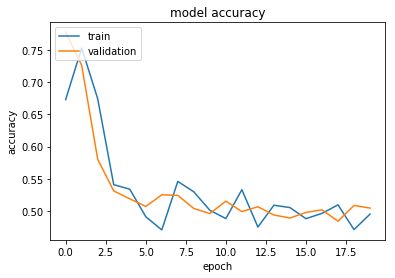

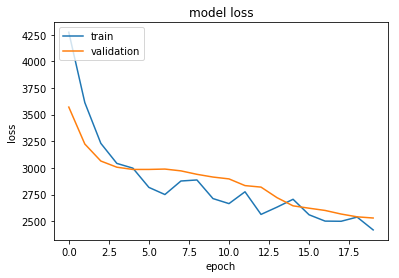

In [22]:
plt.plot(history.history['ac_metrics'])
plt.plot(history.history['val_ac_metrics'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test")
predictions = kpe_model.predict([x_train[:500],x_mask[:500],x_pos[:500]])
print("predictions shape:", predictions.shape)


Generate predictions for test
predictions shape: (500, 154, 1)


In [24]:
calculate_f1(np.where(y_train[:500,:,0]-1==1,1,0),predictions[:,:,0],25,[5,10,15])

F1 [0.10258244 0.1423643  0.15705993] [0.11503333 0.1198881  0.11756605] [0.12188637 0.23476645 0.32375667]


In [ ]:
kpe_model.save('./checkpoints/inspec_final')


In [25]:
t = 259
np.where(predictions[t,:,0][np.where((y_train[t,:,0])>0)]>=0.69)

(array([41], dtype=int64),)

In [26]:
np.argsort(-predictions[t,:,0])

array([ 41,   8,  18,  10,  14,   9,  22,  39,  15,  29,  12,  40,  19,
         7,  11,  44,  30,  13,  17,  34,   6,  36,  27,  35,  20,  28,
        21,  32,  23,  33,  25,  31,  38,  37,  42,  16,  43,   4,  26,
         5,  24,   3,  45,  48,  49,   2,  52,  55,  46,  53,  51,  47,
        54,   1,  50,   0,  57,  58,  59,  56,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83, 153,  84,  85,  86,  87,  88, 152,
        89,  90,  91, 151,  92,  93, 150,  94,  95, 149,  96,  97, 148,
        98, 147,  99, 100, 146, 101, 102, 103, 145, 104, 105, 144, 106,
       107, 143, 108, 109, 142, 110, 111, 141, 112, 113, 140, 114, 139,
       115, 116, 138, 117, 118, 137, 119, 136, 120, 135, 121, 122, 134,
       123, 133, 124, 132, 125, 131, 126, 127, 130, 128, 129], dtype=int64)

In [27]:
np.where((y_train[t,:,0]-1)==1)

(array([ 1,  2,  3,  9, 16, 36], dtype=int64),)

In [33]:

idx = np.argsort(-predictions[t,:,0])
preds = np.where(predictions[t,np.argsort(-predictions[t,:,0])]>=0.5)
scores = predictions [t,idx]
res = np.array(x_pos[t])[:,idx[preds[0]]]
text = tokenizer.decode(list(tf.cast(x_train[t,:],dtype='int32')))
print(text)
keyphrases = collections.defaultdict(float)
for i in range(res.shape[1]):
    phrase = res[:,i]
    phrase = tokenizer.decode(list(tf.cast(x_train[t,phrase[0]:(phrase[1]+1)],dtype='int32')))
    keyphrases[phrase] = max(keyphrases[phrase],scores[i][0])
keyphrases

highperformance numerical pricing methods the pricing of financial derivatives is an important field in finance and constitutes a major component of financial management applications the uncertainty of future events often makes analytic approaches infeasible and hence timeconsuming numerical simulations are required in the aurora financial management system pricing is performed on the basis of lattice representations of stochastic multidimensional scenario processes using the monte carlo simulation and backward induction methods the latter allowing for the exploitation of sharedmemory parallelism we present the parallelization of a backward induction numerical pricing kernel on a cluster of smps using hpf an extended version of highperformance fortran based on language extensions for specifying a hierarchical mapping of data onto an smp cluster the compiler generates a hybridparallel program combining distributedmemory and sharedmemory parallelism we outline the parallelization strateg

defaultdict(float,
            {'uncertainty': 0.70188266,
             'data': 0.681229,
             'sharedmemory parallelism': 0.67231476,
             'financial management applications': 0.6685555,
             'lattice representations': 0.6676677,
             'pricing': 0.66163766,
             'cluster': 0.6468414,
             'distributedmemory': 0.6466232,
             'parallelization': 0.6403377,
             'important field': 0.6362296,
             'extended version': 0.6342048,
             'comparing': 0.6340458,
             'compiler': 0.62809706,
             '': 0.62781626,
             'numerical simulations': 0.6276451,
             'future events': 0.62510103,
             'financial derivatives': 0.6221904,
             'exploitation': 0.6204422,
             'using': 0.61993,
             'latter allowing': 0.6146057,
             'pricing kernel': 0.61282265,
             'basis': 0.61134577,
             'stochastic multidimensional scenario': 0.6080722,
 

In [31]:
x_train[t,phrase[0]:(phrase[1]+1)]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([12503.])>